In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import torch, os, random
import torch.nn as nn
import timm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Classifier(nn.Module):
    def __init__(self, model, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [ ]:
model_type = 'regionA-all'
model_name = 'resnet50' # inception_v4 inception_resnet_v2
hidden_size = 768
pretrained = False
model = timm.create_model(model_name, pretrained=pretrained, num_classes=7)

In [ ]:
classifier = model.to(device) # Classifier(model, num_classes=6).to(device)

In [ ]:
dict_file = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}/{model_name}.pt'
pretrained = torch.load(dict_file)

state_dict = pretrained['state_dict']
labels = pretrained['label']

model_dict = model.state_dict()
model_dict.update(state_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [ ]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [ ]:
def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [ ]:
pkl_file = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}/{model_name}.pickle'
train_epoch, valid_epoch = load_records(pkl_file)
train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']

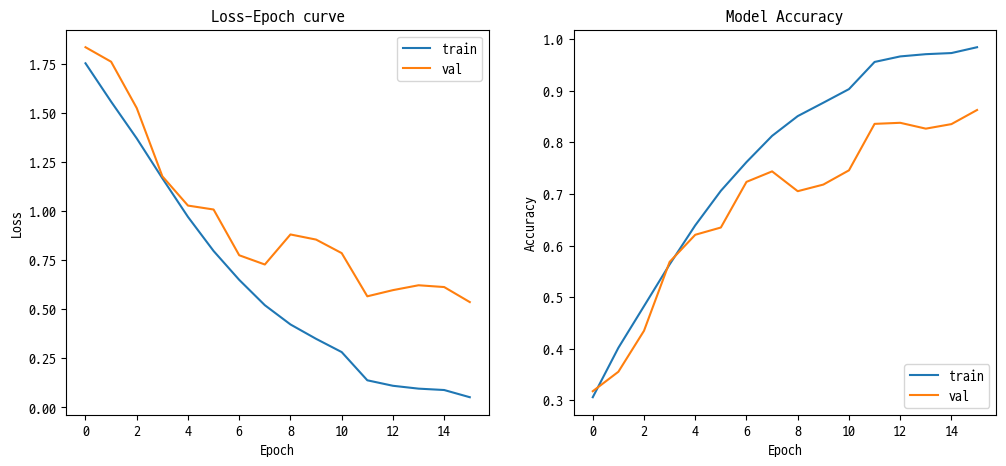

In [ ]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [49]:
print(f"Best Train Acc : {max(train_acc_epoch)} / Best Validation Acc : {max(val_acc_epoch)}")

Best Train Acc : 0.984222027972028 / Best Validation Acc : 0.8625919117647058


In [ ]:
labels

['A1_구진_플라크',
 'A2_비듬_각질_상피성잔고리',
 'A3_태선화_과다색소침착',
 'A4_농포_여드름',
 'A5_미란_궤양',
 'A6_결절_종괴',
 'A7_무증상']

# to .onnx

In [ ]:
classifier.eval()

In [ ]:
model_path = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}'

In [ ]:
torch_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(classifier, torch_input, os.path.join(model_path, f'{model_name}.onnx'))

# onnx inference

In [ ]:
import onnxruntime
from scipy.special import softmax
from PIL import Image
from torchvision.transforms import ToTensor, Normalize

In [ ]:
model_path = f'/content/drive/MyDrive/CV_project/skin_model/{model_type}'

In [ ]:
filepath = os.path.join(model_path, f'{model_name}.onnx')
ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name

In [ ]:
mean_ = (0.5589, 0.5298, 0.5114)
std_ = (0.2119, 0.2031, 0.2015)

In [ ]:
def inference_simple(img_path):

    img = Image.open(img_path)
    # img = img.resize((224, 224))
    img = ToTensor()(img)
    img = Normalize(mean_, std_)(img).unsqueeze(0)

    ort_inputs = {input_name: img.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)

    result = softmax(ort_outs)
    return (result[0][0].argmax(), result[0][0].tolist())

In [ ]:
if not os.path.exists('/content/test_A'):
    os.makedirs('/content/test_A')

In [ ]:
!unzip -qq /content/drive/MyDrive/CV_project/data/SKIN/region/A/test_A.zip -d /content/test_A

In [ ]:
root = '/content/test_A'

for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))

A3_태선화_과다색소침착 716
A4_농포_여드름 369
A2_비듬_각질_상피성잔고리 661
A1_구진_플라크 583
A6_결절_종괴 307
A5_미란_궤양 158
A7_무증상 3130


In [ ]:
predictions = {'target':[], 'pred':[], 'probs':[]}
for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))
    for file in os.listdir(os.path.join(root, folder)):
        predictions['target'].append(int(folder[1])-1)
        inf_result = inference_simple(os.path.join(root, folder, file))
        predictions['pred'].append(inf_result[0])
        predictions['probs'].append(inf_result[1])

        if len(predictions['pred']) % 1000 == 0:
            print(len(predictions['pred']), "done")

A3_태선화_과다색소침착 716
A4_농포_여드름 369
1000 done
A2_비듬_각질_상피성잔고리 661
A1_구진_플라크 583
2000 done
A6_결절_종괴 307
A5_미란_궤양 158
A7_무증상 3130
3000 done
4000 done
5000 done


In [ ]:
from collections import Counter

Counter(predictions['target'])

Counter({2: 716, 3: 369, 1: 661, 0: 583, 5: 307, 4: 158, 6: 3130})

In [ ]:
Counter(predictions['pred'])

Counter({2: 775, 1: 841, 0: 453, 6: 2684, 5: 449, 3: 464, 4: 258})

In [ ]:
preds = list(map(int, predictions['pred'])) # to save json
predictions['pred'] = preds

In [ ]:
import json
with open('/content/drive/MyDrive/CV_project/skin_model/prediction/regionA-resnet50.json', 'w') as f:
    json.dump(predictions, f)

In [ ]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

[Text(0, 0.5, 'A1_구진_플라크'),
 Text(0, 1.5, 'A2_비듬_각질_상피성잔고리'),
 Text(0, 2.5, 'A3_태선화_과다색소침착'),
 Text(0, 3.5, 'A4_농포_여드름'),
 Text(0, 4.5, 'A5_미란_궤양'),
 Text(0, 5.5, 'A6_결절_종괴'),
 Text(0, 6.5, 'A7_무증상')]

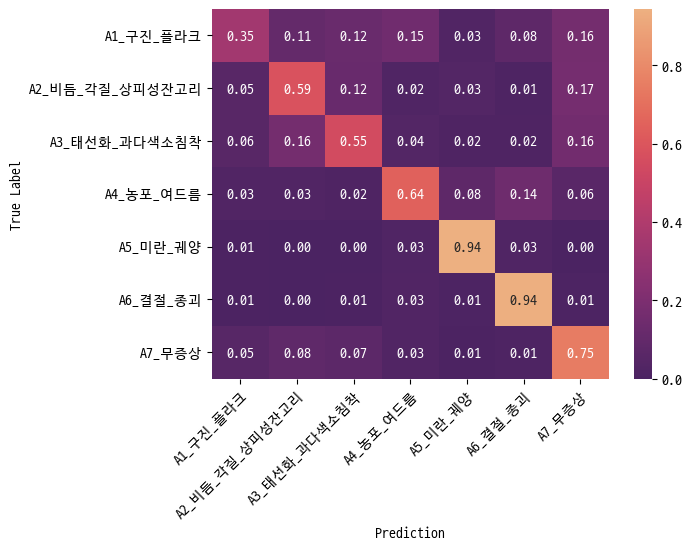

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predictions['target'], predictions['pred'], normalize='true')
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap='flare_r')
hm.set_xlabel('Prediction', fontsize=10)
hm.set_ylabel('True Label', fontsize=10)
hm.set_xticklabels(labels=labels, fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
hm.set_yticklabels(labels=labels, fontsize=10, rotation=0)

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(predictions['target'], predictions['pred'])
print(cr)

              precision    recall  f1-score   support

           0       0.45      0.35      0.39       583
           1       0.46      0.59      0.52       661
           2       0.50      0.55      0.52       716
           3       0.51      0.64      0.57       369
           4       0.58      0.94      0.72       158
           5       0.64      0.94      0.76       307
           6       0.87      0.75      0.80      3130

    accuracy                           0.67      5924
   macro avg       0.57      0.68      0.61      5924
weighted avg       0.70      0.67      0.68      5924



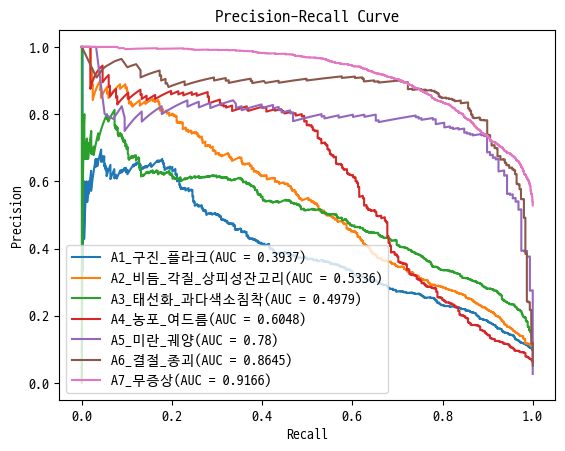

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import numpy as np

legend = []

for i in range(len(labels)):
    target = np.array(predictions['target'])==i
    target = target.astype(int)
    probs = np.array(predictions['probs'])[:, i]

    precision, recall, thresholds = precision_recall_curve(target, probs)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision)
    legend.append(labels[i] + '(AUC = ' + str(round(pr_auc,4)) + ')')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(legend, loc='lower left')
plt.show()